In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Preprocess data

In [7]:
#load data, filter for seasons >= 2010
df = pd.read_csv('game_data.csv')
df = df[df["season"]>=2010]

#add flag for playoffs, remove unnecessary columns
df["Playoffs"] = np.where(df["season_type"]=="REG",0,1)
df.drop(columns=['Unnamed: 0','season_type'],inplace=True)

#split into features and target variable
X = df[['temp','Home_Off_EPA','Away_Off_EPA','Home_Def_EPA','Away_Def_EPA','Playoffs']]
y = df["total"]

In [8]:
#split into training and testing groups
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=df['Playoffs'], random_state=94)

# Build Models

## Model 1: Linear Model

In [9]:
#scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
lin_model = LinearRegression()
lin_model.fit(X_train_scaled,y_train)
lin_rmse = root_mean_squared_error(y_test,lin_model.predict(X_test_scaled))
lin_rmse

12.938877792265412

## Model 2: XGBoost

In [ ]:
#build XGBoost model
xgb_model = xgb.XGBRegressor(
    tree_method="hist",
    n_estimators=1000,          
    learning_rate=0.05,         
    max_depth=5,               
    min_child_weight=1,         
    subsample=0.8,            
    colsample_bytree=0.8,
    early_stopping_rounds=10,   
    eval_metric="rmse",         
    random_state=94)

#fit model
xgb_model.fit(X_train,y_train, eval_set = [(X_test,y_test)])

#compute RMSE
xgb_rmse = root_mean_squared_error(y_test,xgb_model.predict(X_test))
xgb_rmse

[0]	validation_0-rmse:13.65034
[1]	validation_0-rmse:13.62919
[2]	validation_0-rmse:13.59696
[3]	validation_0-rmse:13.58009
[4]	validation_0-rmse:13.52282
[5]	validation_0-rmse:13.47005
[6]	validation_0-rmse:13.42104
[7]	validation_0-rmse:13.40894
[8]	validation_0-rmse:13.37771
[9]	validation_0-rmse:13.33389
[10]	validation_0-rmse:13.30598
[11]	validation_0-rmse:13.28430
[12]	validation_0-rmse:13.28085
[13]	validation_0-rmse:13.25521
[14]	validation_0-rmse:13.22904
[15]	validation_0-rmse:13.20367
[16]	validation_0-rmse:13.17826
[17]	validation_0-rmse:13.16949
[18]	validation_0-rmse:13.15426
[19]	validation_0-rmse:13.13100
[20]	validation_0-rmse:13.11220
[21]	validation_0-rmse:13.09460
[22]	validation_0-rmse:13.07576
[23]	validation_0-rmse:13.07025
[24]	validation_0-rmse:13.05392
[25]	validation_0-rmse:13.04666
[26]	validation_0-rmse:13.04360
[27]	validation_0-rmse:13.03013
[28]	validation_0-rmse:13.01455
[29]	validation_0-rmse:13.00722
[30]	validation_0-rmse:12.99322
[31]	validation_0-

12.950028419494629

## Model 3: Neural Net

In [37]:
#build NN model
nn_model = MLPRegressor(
    hidden_layer_sizes=(100,10,5), 
    activation='relu',          
    solver='adam',         
    max_iter=500,               
    random_state=42            
)

#fit model
nn_model.fit(X_train_scaled,y_train)

#compute RMSE
nn_rmse = root_mean_squared_error(y_test,nn_model.predict(X_test_scaled))
nn_rmse

12.963913619669835

# Evaluating models

## Plot Results

Text(0, 0.5, 'Predicted Points')

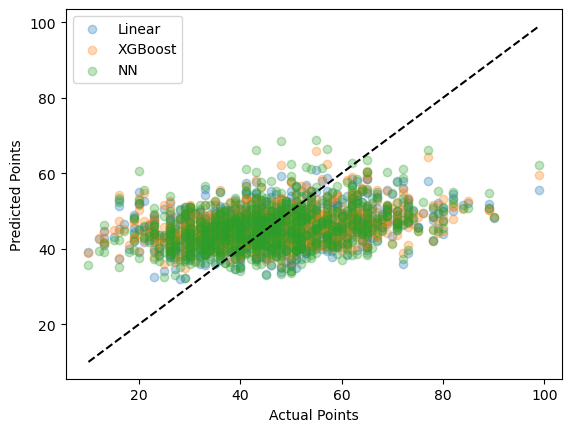

In [38]:
plt.scatter(y_test, lin_model.predict(X_test_scaled), alpha=0.3, label="Linear")
plt.scatter(y_test, xgb_model.predict(X_test), alpha=0.3, label="XGBoost")
plt.scatter(y_test, nn_model.predict(X_test_scaled), alpha=0.3, label="NN")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.legend()
plt.xlabel("Actual Points")
plt.ylabel("Predicted Points")

## Evaluate Accuracy of Over/Under Predictions

In [39]:
#get full dataframe for test games
df_y = df.loc[y_test.index,:]

#get over/under of test games
test_overs = np.where(df_y["total"] > df_y["total_line"],1,0)

#compute over/under predictions
lin_overs = np.where(lin_model.predict(X_test_scaled) > df_y["total_line"],1,0)
xgb_overs = np.where(xgb_model.predict(X_test) > df_y["total_line"],1,0)
nn_overs = np.where(nn_model.predict(X_test_scaled) > df_y["total_line"],1,0)

In [40]:
print("Linear Model Classification Report")
print(classification_report(test_overs,lin_overs))
print("Neural Net Classification Report")
print(classification_report(test_overs,nn_overs))
print("XGBoost Classification Report")
print(classification_report(test_overs,xgb_overs))

Linear Model Classification Report
              precision    recall  f1-score   support

           0       0.61      0.53      0.56       518
           1       0.56      0.63      0.59       486

    accuracy                           0.58      1004
   macro avg       0.58      0.58      0.58      1004
weighted avg       0.58      0.58      0.58      1004

Neural Net Classification Report
              precision    recall  f1-score   support

           0       0.58      0.55      0.56       518
           1       0.55      0.58      0.56       486

    accuracy                           0.56      1004
   macro avg       0.56      0.56      0.56      1004
weighted avg       0.56      0.56      0.56      1004

XGBoost Classification Report
              precision    recall  f1-score   support

           0       0.60      0.52      0.55       518
           1       0.55      0.63      0.58       486

    accuracy                           0.57      1004
   macro avg       0.57      0

In [41]:
#get dataframe for just playoff games
df_y_playoffs = df_y[df_y["Playoffs"]==1]

#get over/under of playoff games
playoff_overs = np.where(df_y_playoffs["total"] > df_y_playoffs["total_line"],1,0)

#compute over/under predictions for playoff games
lin_overs_playoffs = np.where(lin_model.predict(scaler.transform(X_test.loc[df_y_playoffs.index])) > df_y_playoffs["total_line"],1,0)
nn_overs_playoffs = np.where(nn_model.predict(scaler.transform(X_test.loc[df_y_playoffs.index])) > df_y_playoffs["total_line"],1,0)
xgb_overs_playoffs = np.where(xgb_model.predict(X_test.loc[df_y_playoffs.index]) > df_y_playoffs["total_line"],1,0)

In [42]:
print("Linear Model Playoffs Classification Report")
print(classification_report(playoff_overs,lin_overs_playoffs))
print("Neural Net Playoffs Classification Report")
print(classification_report(playoff_overs,nn_overs_playoffs))
print("XGBoost Playoffs Classification Report")
print(classification_report(playoff_overs,xgb_overs_playoffs))

Linear Model Playoffs Classification Report
              precision    recall  f1-score   support

           0       0.62      0.59      0.60        22
           1       0.61      0.64      0.62        22

    accuracy                           0.61        44
   macro avg       0.61      0.61      0.61        44
weighted avg       0.61      0.61      0.61        44

Neural Net Playoffs Classification Report
              precision    recall  f1-score   support

           0       0.65      0.68      0.67        22
           1       0.67      0.64      0.65        22

    accuracy                           0.66        44
   macro avg       0.66      0.66      0.66        44
weighted avg       0.66      0.66      0.66        44

XGBoost Playoffs Classification Report
              precision    recall  f1-score   support

           0       0.56      0.68      0.61        22
           1       0.59      0.45      0.51        22

    accuracy                           0.57        44
   

In [43]:
print(f"Linear Model Accuracy: {accuracy_score(test_overs,lin_overs)}")
print(f"Neural Net Accuracy: {accuracy_score(test_overs,nn_overs)}")
print(f"XGBoost Accuracy: {accuracy_score(test_overs,xgb_overs)}")

Linear Model Accuracy: 0.5786852589641435
Neural Net Accuracy: 0.5637450199203188
XGBoost Accuracy: 0.5697211155378487


In [44]:
print(f"Linear Model Playoff Accuracy: {accuracy_score(playoff_overs,lin_overs_playoffs)}")
print(f"Neural Net Playoff Accuracy: {accuracy_score(playoff_overs,nn_overs_playoffs)}")
print(f"XGBoost Playoff Accuracy {accuracy_score(playoff_overs,xgb_overs_playoffs)}")

Linear Model Playoff Accuracy: 0.6136363636363636
Neural Net Playoff Accuracy: 0.6590909090909091
XGBoost Playoff Accuracy 0.5681818181818182
